In [1]:
import sys
from imutils import paths
import os
import numpy as np
from tensorflow.keras import callbacks, Sequential
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, AveragePooling2D
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
PATH_TO_IMAGE = "./data/"
MODELS_PATH = "./models/"
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 100
BS = 32

In [3]:
print(PATH_TO_IMAGE)
print(MODELS_PATH)
for img_path in list(paths.list_images(PATH_TO_IMAGE)):
        print(img_path)

./data/
./models/
./data/without_mask\without_mask_1.jpg
./data/without_mask\without_mask_10.jpg
./data/without_mask\without_mask_100.jpg
./data/without_mask\without_mask_1000.jpg
./data/without_mask\without_mask_1001.jpg
./data/without_mask\without_mask_1002.jpg
./data/without_mask\without_mask_1003.jpg
./data/without_mask\without_mask_1004.jpg
./data/without_mask\without_mask_1005.jpg
./data/without_mask\without_mask_1006.jpg
./data/without_mask\without_mask_1007.jpg
./data/without_mask\without_mask_1008.jpg
./data/without_mask\without_mask_1009.jpg
./data/without_mask\without_mask_101.jpg
./data/without_mask\without_mask_1010.jpg
./data/without_mask\without_mask_1011.jpg
./data/without_mask\without_mask_1012.jpg
./data/without_mask\without_mask_1013.jpg
./data/without_mask\without_mask_1014.jpg
./data/without_mask\without_mask_1015.jpg
./data/without_mask\without_mask_1016.jpg
./data/without_mask\without_mask_1017.jpg
./data/without_mask\without_mask_1018.jpg
./data/without_mask\wit

./data/with_mask\with_mask_1128.jpg
./data/with_mask\with_mask_1129.jpg
./data/with_mask\with_mask_113.jpg
./data/with_mask\with_mask_1130.jpg
./data/with_mask\with_mask_1131.jpg
./data/with_mask\with_mask_1132.jpg
./data/with_mask\with_mask_1133.jpg
./data/with_mask\with_mask_1134.jpg
./data/with_mask\with_mask_1135.jpg
./data/with_mask\with_mask_1136.jpg
./data/with_mask\with_mask_1137.jpg
./data/with_mask\with_mask_1138.jpg
./data/with_mask\with_mask_1139.jpg
./data/with_mask\with_mask_114.jpg
./data/with_mask\with_mask_1140.jpg
./data/with_mask\with_mask_1141.jpg
./data/with_mask\with_mask_1142.jpg
./data/with_mask\with_mask_1143.jpg
./data/with_mask\with_mask_1144.jpg
./data/with_mask\with_mask_1145.jpg
./data/with_mask\with_mask_1146.jpg
./data/with_mask\with_mask_1147.jpg
./data/with_mask\with_mask_1148.jpg
./data/with_mask\with_mask_1149.jpg
./data/with_mask\with_mask_115.jpg
./data/with_mask\with_mask_1150.jpg
./data/with_mask\with_mask_1151.jpg
./data/with_mask\with_mask_1152

In [4]:
data = []
labels = []

for img_path in list(paths.list_images(PATH_TO_IMAGE)):
    # extract the class label from the filename
    label = img_path.split(os.path.sep)[-2]

    # load the input image as (224x224) and preprocess it
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

C:\Users\HYUMA\.conda\envs\kadu\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [5]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
print(labels)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [6]:
(x_train, x_test, y_train, y_test) = train_test_split(data, labels, test_size=0.10, stratify=labels, random_state=42)
(x_train, x_test, y_train, y_test) = (np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test))

In [7]:
# load the MobileNetV2 network, left off the head FC layer sets
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = Sequential(baseModel)
headModel.add(AveragePooling2D(pool_size=(7, 7)))
headModel.add(Flatten(name="flatten"))
headModel.add(Dense(128, activation="relu"))
headModel.add(Dropout(0.5))
headModel.add(Dense(2, activation="softmax"))

    # place the head FC model on top of the base model
model = headModel  # Model(inputs=baseModel.input, outputs=headModel)
print(model.summary())

    # freeze layers of base models so they will
    # *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 2,422,210
Trainable params: 2,388,098
Non-trainable params: 34,112
_________________________________________

In [8]:
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode="nearest",
                         validation_split=0.2)

In [9]:
train_generator = aug.flow(x_train, y_train, batch_size=BS, subset="training")
val_generator = aug.flow(x_train, y_train, batch_size=BS, subset="validation")

In [10]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [11]:
model_callbacks = [callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=2, verbose=0, mode='auto'),
                   callbacks.ModelCheckpoint(
                   filepath=os.path.join(MODELS_PATH, 'weights-{epoch:02d}-{accuracy:.2f}.hdf5'),
                   save_weights_only=True,
                   monitor='accuracy',
                   mode='max',
                   save_best_only=True)]

In [12]:
H = model.fit(
    train_generator,
    steps_per_epoch=int(np.ceil(train_generator.n / float(BS))),
    validation_data=val_generator,
    validation_steps=int(np.ceil(val_generator.n / float(BS))),  # int(np.ceil(len(x_test) / BS)),
    epochs=10,
    callbacks=model_callbacks
)

Epoch 1/10
170/170 [==============================] - 54s 294ms/step - loss: 0.5193 - accuracy: 0.7787 - val_loss: 0.1047 - val_accuracy: 0.9816
Epoch 2/10
170/170 [==============================] - 49s 288ms/step - loss: 0.1250 - accuracy: 0.9699 - val_loss: 0.0691 - val_accuracy: 0.9794
Epoch 3/10
170/170 [==============================] - 48s 285ms/step - loss: 0.0745 - accuracy: 0.9816 - val_loss: 0.0434 - val_accuracy: 0.9897
Epoch 4/10
170/170 [==============================] - 48s 284ms/step - loss: 0.0601 - accuracy: 0.9801 - val_loss: 0.0495 - val_accuracy: 0.9838
Epoch 5/10
170/170 [==============================] - 48s 283ms/step - loss: 0.0531 - accuracy: 0.9870 - val_loss: 0.0449 - val_accuracy: 0.9890
Epoch 6/10
170/170 [==============================] - 48s 284ms/step - loss: 0.0505 - accuracy: 0.9846 - val_loss: 0.0373 - val_accuracy: 0.9897
Epoch 7/10
170/170 [==============================] - 48s 284ms/step - loss: 0.0433 - accuracy: 0.9871 - val_loss: 0.0393 - val_ac

In [13]:
id_pred = model.predict(x_test, batch_size=BS)

In [14]:
id_pred = np.argmax(id_pred, axis=1)

In [15]:
print(classification_report(y_test.argmax(axis=1), id_pred,
                                target_names=["without_mask", "with_mask"]))

              precision    recall  f1-score   support

without_mask       0.99      0.98      0.99       373
   with_mask       0.98      0.99      0.99       383

    accuracy                           0.99       756
   macro avg       0.99      0.99      0.99       756
weighted avg       0.99      0.99      0.99       756



In [17]:
model.save(os.path.join(MODELS_PATH, "mask_mobilenet.h5"), save_format="h5")

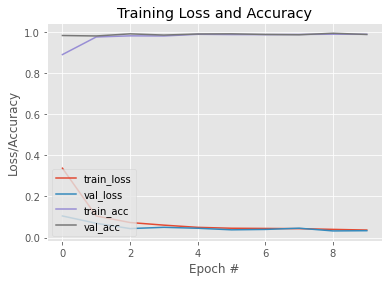

In [18]:
# plot the training loss and accuracy
N = len(H.epoch)
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(os.path.join(MODELS_PATH, "training_plot.png"))
report_df = pd.DataFrame({
    "loss": H.history["loss"],
    "val_accuracy": H.history["val_accuracy"],
    "val_loss": H.history["val_loss"],
    "accuracy": H.history["accuracy"]
})
report_df.to_csv(os.path.join(MODELS_PATH, "model_report.csv"))